## Modèle en production

Laurent Cetinsoy - Datadidacte

Une des supposition centrale pour qu'un modèle de machine learning marche est que la distribution des données ne diffère pas de celle des données d'entrainement.

On ne peut garantir la généralisation d'un modèle que si la distribution des données est similaire à celle de la distribution $ X_{prod} \tilde{} \,  P_{train}$

Ainsi, si les données que le modèle voient en production n'ont pas la même distribution (ne ressemblent pas) aux données de train, alors le modèle aura peu de chance de faire de bonne prédictions.

Il est donc important de surveille les données vues par le modèle en production.

Pour cela on va mesurer ce qu'on appelle le Data drift : on va mesurer à quel point les données s'écartent des données de train.

Et on pourra ainsi lever une alerte si c'est le cas.

## Utilisation Eurybia



En consultant la documentation de Eurybia (https://eurybia.readthedocs.io/en/latest/overview.html), expliquer le principe de fonctionnement de Euribya :

- A quoi sert le modèle de classification ?
- A-t-on besoin d’avoir les labels issus de la production pour pouvoir utiliser cette approche ?
- Quel est le critère pour déterminer qu’il y a un data-drift ?


- A quoi sert le modèle de classification ?\
Il sert à prédire si un échantillon de données est issu de la distribution de données d'entrainement ou non.
- A-t-on besoin d’avoir les labels issus de la production pour pouvoir utiliser cette approche ?\
Non, on n'a pas besoin des labels, on a juste besoin des X de production.
- Quel est le critère pour déterminer qu’il y a un data-drift ?\
On observe les performances du modèle de classification. Plus précisément, on regarde la probabilité que le modèle prédise bien l'échantillon dont est issu l'échantillon (AUR). Si cette probabilité est faible 0.5 (équilibre), alors on peut dire qu'il n'y a un data-drift, plus on se rapproche de 1, plus il y a un data-drift.

Installer eurybia

In [1]:
# pip install eurybia

Utiliser eurybia pour monitorer le modèle. Dans un premier temps faire en sorte que les données (df_current) soient de la même distribution que vos données d’entraînement. Vérifier que Eurybia pense que le modèle ne drift pas


In [2]:
import eurybia
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

/opt/anaconda3/envs/mlops/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
houses_df = pd.read_csv("houses.csv")

le = LabelEncoder()
houses_df["orientation"] = le.fit_transform(houses_df["orientation"])

old_df, df_current = train_test_split(houses_df, test_size=0.5, random_state=42)
old_df_train, old_df_test = train_test_split(old_df, test_size=0.2, random_state=42)

print(old_df_train.shape, old_df_test.shape, df_current.shape)
houses_df.head()

(16, 5) (4, 5) (20, 5)


,size,nb_rooms,garden,orientation,price
0,205.999169,2,0,2,260972.164975
1,186.559166,2,0,2,256534.245748
2,187.143785,1,1,0,282674.291717
3,83.315363,2,1,0,266555.384156
4,161.781580,2,1,3,319158.418695


In [4]:
model = RandomForestRegressor()
model.fit(old_df_train[["size", "nb_rooms", "garden", "orientation"]], old_df_train["price"])
y_pred = model.predict(old_df_test[["size", "nb_rooms", "garden", "orientation"]])
mse = mean_squared_error(old_df_test["price"], y_pred)
print(mse)

83300473245.00822


In [5]:
sd = eurybia.SmartDrift(
  df_current=df_current.drop(columns=["price"]), # Current dataset
  df_baseline=old_df_train.drop(columns=["price"]), # Baseline dataset
  deployed_model=model, # Optional: put in perspective result with importance on deployed model
  dataset_names={"df_current": "Current dataset Name", "df_baseline": "Baseline dataset Name"} # Optional: Names for outputs
)
sd.compile(
  date_compile_auc='01/01/2022', # Optional: useful when computing the drift for a time that is not now
  datadrift_file="datadrift_auc_train_vs_current.csv", # Optional: name of the csv file that contains the performance history of data drift
)
sd.generate_report(
  output_file='train_vs_current_report.html',
  title_story="train_vs_current_report",
)

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x13e06ca10>
The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.45000000000000007


/opt/anaconda3/envs/mlops/lib/python3.11/site-packages/eurybia/report/generation.py:17: UserWarning:

Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.



Faire de même avec des données de test. Les données de tests ont-elle un drift par rapport au train ?


In [6]:
sd = eurybia.SmartDrift(
  df_current=old_df_test.drop(columns=["price"]), # Current dataset
  df_baseline=old_df_train.drop(columns=["price"]), # Baseline dataset
  deployed_model=model, # Optional: put in perspective result with importance on deployed model
  dataset_names={"df_current": "Current dataset Name", "df_baseline": "Baseline dataset Name"} # Optional: Names for outputs
)
sd.compile(
  date_compile_auc='01/01/2022', # Optional: useful when computing the drift for a time that is not now
  datadrift_file="datadrift_auc_train_vs_test.csv", # Optional: name of the csv file that contains the performance history of data drift
)
sd.generate_report(
  output_file='train_vs_test_report.html',
  title_story="train_vs_test_report",
)

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x13e06d0d0>
The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.5


Générer des données qui ne ressemblent ni au train ni au test (par exemple avec des données abérentes). Euribya détecte-t-il ces données ?

In [7]:
df_aberrant = pd.DataFrame({
    "size": [401000.0, 400000.2, 0.2, 10000.0, 694200.2],
    "nb_rooms": [3, 50, 500, 1, 2],
    "garden": [1, 0, 1, 0, 1],
    "orientation": [0, 1, 2, 3, 1],
})
df_aberrant

,size,nb_rooms,garden,orientation
0,401000.0,3,1,0
1,400000.2,50,0,1
2,0.2,500,1,2
3,10000.0,1,0,3
4,694200.2,2,1,1


In [8]:
sd = eurybia.SmartDrift(
  df_current=df_aberrant, # Current dataset
  df_baseline=old_df_train.drop(columns=["price"]), # Baseline dataset
  deployed_model=model, # Optional: put in perspective result with importance on deployed model
  dataset_names={"df_current": "Current dataset Name", "df_baseline": "Baseline dataset Name"} # Optional: Names for outputs
)
sd.compile(
  date_compile_auc='01/01/2022', # Optional: useful when computing the drift for a time that is not now
  datadrift_file="datadrift_auc_train_vs_abberant.csv", # Optional: name of the csv file that contains the performance history of data drift
)

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x140d451d0>
The computed AUC on the X_test used to build datadrift_classifier is equal to: 1.0


Eurybia a detecté un drift sur les données de test. AUC = 1.0.

## Alibaba detect

Dans cette partie on va utiliser la librairie https://github.com/SeldonIO/alibi-detect pour faire la détection de problèmes
Installer la librairie avec pip

In [9]:
# pip install alibi-detect[tensorflow]

Charger le jeu de donnée cifar10 avec keras et récupérer le train et le test puis,

Normaliser les données de train en faisant un MinMaxScaling (diviser par 255)

In [10]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

2024-11-07 15:34:00.877760: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


170498071/170498071 [==============================] - 177s 1us/step


In [11]:
# min-max scale the images
x_train = x_train / 255.
x_test = x_test / 255.

Dans le sous package alibbi_detect.datasets importer les  fonction fetch_cifar10c et corruption_types_cifar10c

In [28]:
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

Afficher les types de corruption de données disponible avec la fonction corruption_types_cifar10c

In [30]:
corruption_types_cifar10c()

['brightness',
 'contrast',
 'defocus_blur',
 'elastic_transform',
 'fog',
 'frost',
 'gaussian_blur',
 'gaussian_noise',
 'glass_blur',
 'impulse_noise',
 'jpeg_compression',
 'motion_blur',
 'pixelate',
 'saturate',
 'shot_noise',
 'snow',
 'spatter',
 'speckle_noise',
 'zoom_blur']

Avec la fonction fetch_cifar10c récupérer des exemples corrompus de donnée ressemblant à cifar 10 et les stocker dans des variable X_corrupted et y_corrupted.

Vous choisirez au moins les corruptions suivantes : ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']

Vous spécifirez les argument severity=5 et return_X_y=True

In [31]:
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X, y = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)

Normaliser les images corrompues

In [32]:
X = X / 255.

Afficher plusieurs des images corrompues.

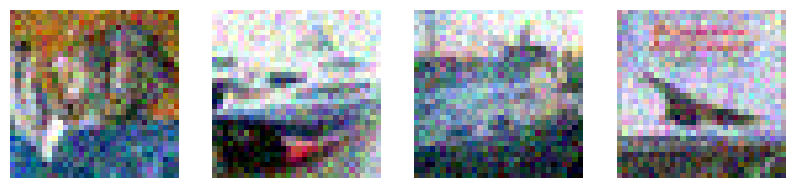

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')

On va maintenant prendre un modèle entraîné sur cifar10 pour voir l'impact des performances sur le modèle.

Avec la fonction  fetch_tf_model du module alibi_detect.utils.fetching, charger le modèle préentraîné resnet32 sur cifar10


In [34]:
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
dataset = 'cifar10'
model_name = 'resnet32'
model = fetch_tf_model(dataset, model_name)

Calculer la performance du model sur le jeu de train et de test

In [38]:
from sklearn.metrics import classification_report

y_pred_train = model.predict(x_train)
print(classification_report(y_train, np.argmax(y_pred_train, axis=1)))

1563/1563 [==============================] - 57s 36ms/step
              precision    recall  f1-score   support

           0       0.50      0.92      0.65      5000
           1       1.00      0.58      0.74      5000
           2       0.86      0.40      0.55      5000
           3       0.37      0.81      0.50      5000
           4       0.69      0.50      0.58      5000
           5       0.52      0.67      0.58      5000
           6       0.76      0.53      0.63      5000
           7       0.99      0.52      0.68      5000
           8       0.64      0.78      0.70      5000
           9       0.97      0.45      0.61      5000

    accuracy                           0.62     50000
   macro avg       0.73      0.62      0.62     50000
weighted avg       0.73      0.62      0.62     50000



In [39]:
y_pred_test = model.predict(x_test)
print(classification_report(y_test, np.argmax(y_pred_test, axis=1)))

313/313 [==============================] - 11s 36ms/step
              precision    recall  f1-score   support

           0       0.50      0.89      0.64      1000
           1       0.99      0.59      0.74      1000
           2       0.81      0.40      0.54      1000
           3       0.35      0.78      0.48      1000
           4       0.67      0.48      0.56      1000
           5       0.51      0.66      0.57      1000
           6       0.75      0.54      0.63      1000
           7       0.99      0.52      0.68      1000
           8       0.62      0.73      0.67      1000
           9       0.97      0.45      0.61      1000

    accuracy                           0.60     10000
   macro avg       0.72      0.60      0.61     10000
weighted avg       0.72      0.60      0.61     10000



Calculer la performance du modèle sur le jeu de donnée corrompu. Vous devriez observer qu'il chute significativement

In [37]:
y_pred = model.predict(X)
print(classification_report(y, y_pred.argmax(axis=1)))

1250/1250 [==============================] - 55s 44ms/step
              precision    recall  f1-score   support

           0       0.24      0.48      0.32      4000
           1       0.99      0.13      0.23      4000
           2       0.18      0.30      0.23      4000
           3       0.22      0.32      0.26      4000
           4       0.37      0.20      0.26      4000
           5       0.30      0.21      0.25      4000
           6       0.37      0.25      0.29      4000
           7       0.99      0.13      0.23      4000
           8       0.16      0.43      0.24      4000
           9       0.81      0.11      0.20      4000

    accuracy                           0.26     40000
   macro avg       0.46      0.26      0.25     40000
weighted avg       0.46      0.26      0.25     40000



On va maintenant voir comment détecter les changement de distributions de données.

Pour les données non tabulaire ou à haute dimension on procéde généralement en deux étapes :

1. Faire une réduction de dimension
2. Faire un test permettant de voir si les données projetées ont changé de distribution ou pas

Il existe plusieurs manières de faire de la réduction de dimension. La plus classique est la PCA.

Il est possible également d'utiliser des Auto-encoder

Le code suivant permet de créer la première partie (l'encoder) d'un auto-encoder simple qui nous servira à réduire les dimension des données.

In [41]:
from functools import partial
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift

tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

Le drift detector a besoin d'une donnée de référence afin d'effectuer la comparaison avec les données à monitorer.
Créer une variable X_ref avec un échantillon aléatoire des données de test

In [42]:
X_ref = x_test[:100]

A quoi sert le test statistique kolmogorov smirnoff ?

Instancier la classe KSDrift dans une variable nommée **detector**

Il faut lui passer le dataset de reference, une p value (prendre 0.05) et une fonction permettant de faire le preprocessing. On a créé la fonction pour vous


In [ ]:
from alibi_detect.cd.tensorflow import preprocess_drift
preprocess_function = partial(preprocess_drift, model=encoder_net, batch_size=32)

A laide du Drift detector et la méthode predict faire des prediction sur les données de test et sur les données corrompue pour voir si il détecte un changement de distribution